In [3]:
pip install onnxruntime-gpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.8/280.8 MB 520.1 kB/s eta 0:00:00m eta 0:00:010:00:17
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install onnx   

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 8.7 MB/s eta 0:00:000:00:010:00:01:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
!pip install tf2onnx  
!pip install onnxruntime 

  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uninstalled protobuf-5.29.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 5.5 MB/s eta 0:00:000:00:01m eta 0:00:01


In [1]:
import os
import shutil
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, preprocessing, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19, ResNet50V2, VGG16
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, load_model

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import onnx
import tf2onnx
import onnxruntime as ort

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(f"Could not set memory growth: {e}")

def convert_to_onnx(model: tf.keras.Model, output_path: str, opset: int = 13):
    """
    Converts a tf.keras model to ONNX format.

    Args:
      model: Trained tf.keras.Model instance.
      output_path: Where to save the .onnx file.
      opset: ONNX opset version to target.
    """
    spec = (tf.TensorSpec(model.input_shape, tf.float32, name="input"),)
    onnx_model, _ = tf2onnx.convert.from_keras(model,
                                               input_signature=spec,
                                               output_path=output_path,
                                               opset=opset)
    print(f"ONNX model saved to: {output_path}")
    return onnx_model

2025-04-30 17:28:35.316505: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-30 17:28:35.324228: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746016115.333082 3512463 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746016115.335844 3512463 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746016115.342848 3512463 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

**Data Partition**

In [3]:
IMG_PATH = '/home/fast/Downloads/brain_tumor_dataset'

# Ensure target dirs exist
for split in ['TRAIN', 'TEST']:
    for cls in os.listdir(IMG_PATH):
        if cls.startswith('.'):
            continue
        os.makedirs(os.path.join('..', split, cls.upper()), exist_ok=True)

for cls in os.listdir(IMG_PATH):
    if cls.startswith('.'):
        continue

    cls_path = os.path.join(IMG_PATH, cls)
    files = [f for f in os.listdir(cls_path) if not f.startswith('.')]
    total = len(files)

    for n, fname in enumerate(files):
        src = os.path.join(cls_path, fname)
        # compare against integer threshold
        if n < int(0.2 * total):
            dst = os.path.join('../TEST/',  cls.upper(), fname)
        else:
            dst = os.path.join('../TRAIN/', cls.upper(), fname)
        shutil.copy2(src, dst)


**Data Preprocessing**

In [4]:
#intializing the image size and batch size
height = 244
width = 244
batch_size=10
dataset_dir = '../TRAIN/'
test_dir  = '../TEST/'

def image_gen(height, width, batch_size):
    
    datagen = ImageDataGenerator(
        rescale=1./255.,
    )

    train_ds = datagen.flow_from_directory(
        dataset_dir,
        batch_size=batch_size,
        subset="training",
        color_mode="rgb",
        class_mode='binary',
        shuffle=True,
        target_size=(height, width),
    )
    
    test_ds = datagen.flow_from_directory(
        test_dir,
        batch_size=batch_size,
        shuffle=True,
        color_mode="rgb",
        class_mode="binary",
        target_size=(height, width),
    )

    return train_ds, test_ds

def augmented_data(height, width):

    datagen = ImageDataGenerator(
        rescale= 1./255.,
        width_shift_range= 0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        rotation_range=30,
        horizontal_flip=True,
        brightness_range=(0.5, 1.0)
    )
    
    train_ds = datagen.flow_from_directory(
        dataset_dir,
        batch_size=batch_size,
        shuffle=True,
        color_mode="rgb",
        class_mode="binary",
        target_size=(height, width),
    )
    
    return train_ds

train_ds, test_ds = image_gen(height, width, batch_size)

total_images = np.concatenate([train_ds.labels, test_ds.labels])
# Print the count of images in each class
print({"No brain tumor cases": len(np.where(total_images == 0)[0]),
       "Brain tumor cases": len(np.where(total_images == 1)[0])})

Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
{'No brain tumor cases': 98, 'Brain tumor cases': 155}


**Data Samples**

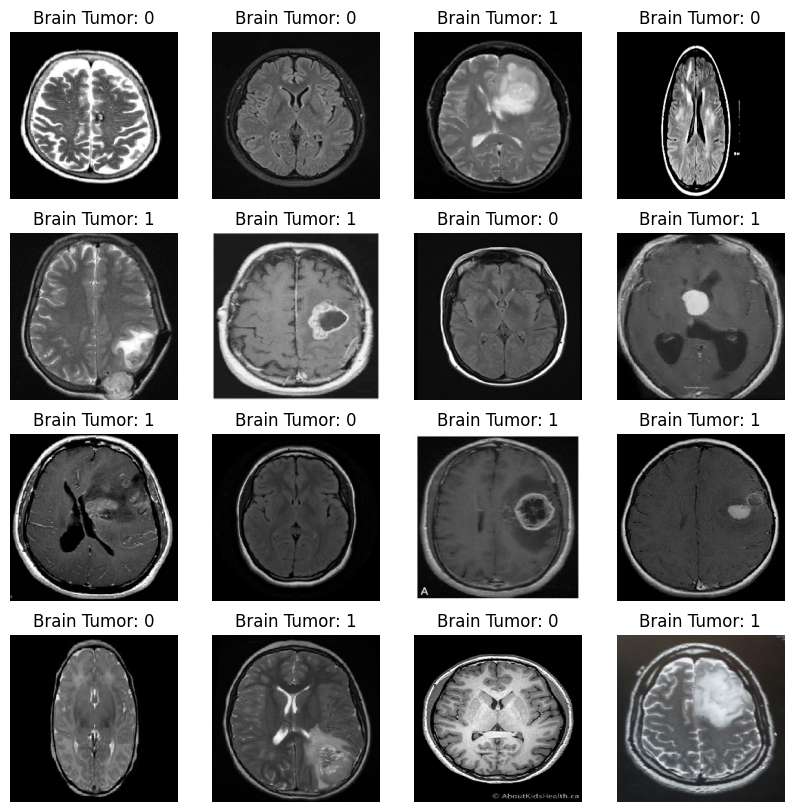

In [5]:
fig, ax = plt.subplots(4,4, figsize=(10,10))
for k in range(16):
    images, labels = next(iter(train_ds))
    #print(images[0].shape)
    i, j = k//4, k%4
    ax[i, j].imshow(images[0])
    ax[i, j].set_title(f"Brain Tumor: {int(labels[0])}")
    ax[i, j].axis('off')
plt.show()

**Helper Function - Plots Accuracy and Loss Curves**

In [6]:
def plots(training_acc, testing_acc, training_loss, testing_loss, infer_time, onnx_infer_time):
  
  acc_categories = ['Training Accuracy', 'Testing Accuracy']
  acc_values = [training_acc, testing_acc]
  plt.figure(figsize=[12,6])

  plt.subplot(1, 3, 1)
  plt.bar(acc_categories, acc_values, width=0.2, color='green')
  plt.title('Training Vs Testing Accuracy')
  plt.ylabel('Accuracy')

  loss_categories = ['Training Loss', 'Testing Loss']
  loss_values = [training_loss, testing_loss]
  plt.subplot(1, 3, 2)
  plt.bar(loss_categories, loss_values, width=0.2)
  plt.title('Training Vs Testing Loss')
  plt.ylabel('Loss')

  infer_categories = ['Tensorflow Latency', 'ONNX Latency']
  infer_values = [infer_time, onnx_infer_time]
  plt.subplot(1, 3, 3)
  plt.bar(infer_categories, infer_values, width=0.2, color='red')
  plt.title('Tensorflow vs ONNX Latency')
  plt.ylabel('Latency (sec)')
  plt.show()
  

In [7]:
def plot_confusion_matrix(model, data):
    predictions = model.predict(data)
    labels = np.where(predictions>0.5,1,0)
    cm = confusion_matrix(data.labels, labels)
    plt.figure(figsize=(8,8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Tumor','No Tumor'])
    disp.plot()
    plt.title('Confusion Matrix')
    plt.grid(False)
    plt.xticks(rotation ='vertical')
    plt.show()

**ResNet50V2 - Deep Neural Network**

In [18]:
conda install -c conda-forge cudatoolkit=11.7 cudnn=9.3

Retrieving notices: done
Channels:
 - conda-forge
 - defaults
Platform: linux-64
Solving environment: done


==> WARNING: A newer version of conda exists. <==
    current version: 25.1.1
    latest version: 25.3.1

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/fast/miniconda3

  added / updated specs:
    - cudatoolkit=11.7
    - cudnn=9.3


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2025.4.26  |       hbd8a1cb_0         149 KB  conda-forge
    conda-25.3.1               |  py312h7900ff3_1         1.1 MB  conda-forge
    cuda-version-11.7          |       h67201e3_3          21 KB  conda-forge
    cudatoolkit-11.7.1         |      h4bc3d14_13       589.5 MB  conda-forge
    cudnn-9.3.0.75             |       hf36481c_2       379.2 MB  conda-forge
    icu-75.1                   |      

In [8]:
base_model = ResNet50V2(input_shape=(244,244,3), include_top=False)
base_model.trainable = False

model = Sequential([
    base_model, 
    GlobalAveragePooling2D(),
    Dense(256, activation="relu", kernel_initializer='he_normal'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer=Adam(), 
               loss="binary_crossentropy", 
               metrics=['accuracy'])

model.summary()

checkpoint = tf.keras.callbacks.ModelCheckpoint('../models/resnet50v2_best.h5', 
                                                monitor='accuracy', verbose=1, 
                                                mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="accuracy", mode="max", restore_best_weights=True, patience=5)
callbacks_list = [checkpoint,early]

history = model.fit(train_ds, epochs=30, callbacks=callbacks_list)

I0000 00:00:1746015467.479984 3506066 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13651 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:01:00.0, compute capability: 8.6
2025-04-30 17:17:47.597438: W external/local_xla/xla/service/gpu/llvm_gpu_backend/default/nvptx_libdevice_path.cc:40] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  ./cuda_sdk_lib
  ipykernel_launcher.runfiles/cuda_nvcc
  ipykern/cuda_nvcc
  
  /usr/local/cuda
  /opt/cuda
  /home/fast/miniconda3/lib/python3.12/site-packages/tensorflow/python/platform/../../../nvidia/cuda_nvcc
  /home/fast/miniconda3/lib/python3.12/site-packages/tensorflow/python/platform/../../../../nvidia/cuda_nvcc
  /home/fast/miniconda3/lib/python3.12/site-packages/tensorflow/python/platform/../../cuda
  /home/fast/minico

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 8, 8, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,089,601 (91.89 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

Epoch 1/30


/home/fast/miniconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1746015471.563160 3506598 service.cc:152] XLA service 0x769e58041a00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746015471.563194 3506598 service.cc:160]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2025-04-30 17:17:51.631225: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
E0000 00:00:1746015472.209640 3506598 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.1.0 but source was compiled with: 9.3.0.  CuDNN libr

FailedPreconditionError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/fast/miniconda3/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/fast/miniconda3/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/fast/miniconda3/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/fast/miniconda3/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/home/fast/miniconda3/lib/python3.12/asyncio/base_events.py", line 639, in run_forever

  File "/home/fast/miniconda3/lib/python3.12/asyncio/base_events.py", line 1985, in _run_once

  File "/home/fast/miniconda3/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/home/fast/miniconda3/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/fast/miniconda3/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/fast/miniconda3/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/fast/miniconda3/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/fast/miniconda3/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/fast/miniconda3/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/fast/miniconda3/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/fast/miniconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3098, in run_cell

  File "/home/fast/miniconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3153, in _run_cell

  File "/home/fast/miniconda3/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/fast/miniconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3362, in run_cell_async

  File "/home/fast/miniconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3607, in run_ast_nodes

  File "/home/fast/miniconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3667, in run_code

  File "/tmp/ipykernel_3506066/2782142171.py", line 23, in <module>

  File "/home/fast/miniconda3/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/fast/miniconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/home/fast/miniconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/home/fast/miniconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

DNN library initialization failed. Look at the errors above for more details.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_multi_step_on_iterator_10624]

In [173]:
model = load_model('../models/resnet50v2_best.h5')
start_time = time.time()
history_2 = model.evaluate(test_ds)
end_time = time.time()
inference_time = (end_time-start_time)
print(f"Inference time: {(inference_time)}")


5/5 [==============================] - 8s 1s/step - loss: 0.8659 - accuracy: 0.8000
Inference time: 7.95610237121582


In [98]:
output_path = "../models/resnet50v2_best.onnx"
spec = [(tf.TensorSpec(shape=(None, 244, 244, 3), dtype=tf.float32, name="input"))]

model_proto, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=13)
onnx.save_model(model_proto, output_path)


Could not search for non-variable resources. Concrete function internal representation may have changed.


In [170]:
providers = ['CPUExecutionProvider']
session = ort.InferenceSession(output_path, providers=providers)
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

correct_predictions_total = 0
total_inference_time = 0
n_samples = 0

for batch in (test_ds):

    image, label = batch
    input_data = image

    start_time = time.time()
    onnx_pred = session.run([output_name], {input_name: input_data})
    end_time = time.time()
    
    threshold = 0.5
    binary_predictions = (onnx_pred[0] > threshold).astype(int)

    inference_time = (end_time-start_time)
    total_inference_time +=inference_time

    correct_predictions_batch = (binary_predictions.T == label)
    correct_predictions_total += np.sum(correct_predictions_batch)
    n_samples += len(label)

    if test_ds.batch_index == 0:
        break

print(f"Correct predictions: {correct_predictions_total}")
print(f"Total predictions: {n_samples}")
accuracy = (correct_predictions_total/n_samples)
onnx_inference_time = total_inference_time/len(test_ds)
print(f"Accuracy {accuracy:.2f}")
print(f"Inference time: {onnx_inference_time:.4f}")

Correct predictions: 38
Total predictions: 50
Accuracy 0.76
Inference time: 0.8694


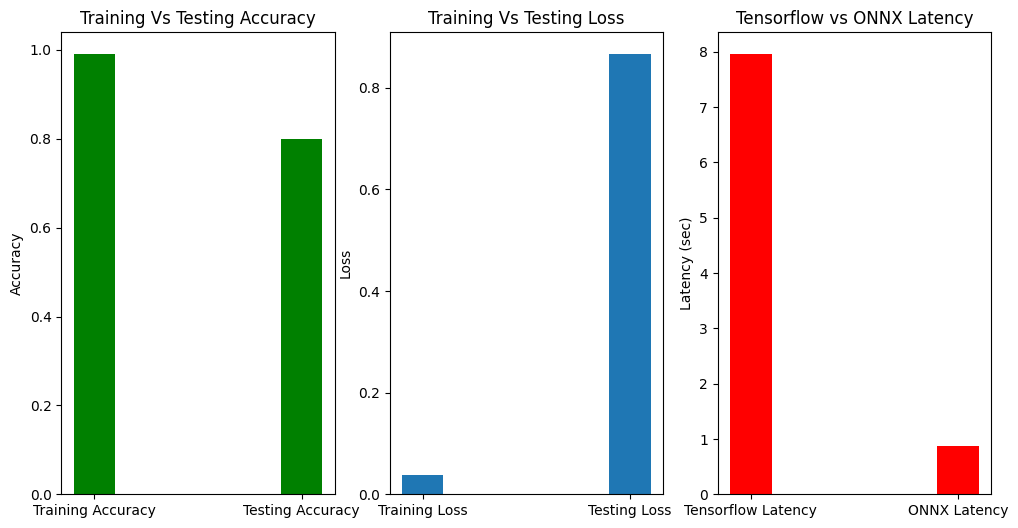

In [174]:
plots(history.history['accuracy'][-1], history_2[1], history.history['loss'][-1], history_2[0],
       inference_time, onnx_inference_time)

5/5 [==============================] - 10s 2s/step


<Figure size 800x800 with 0 Axes>

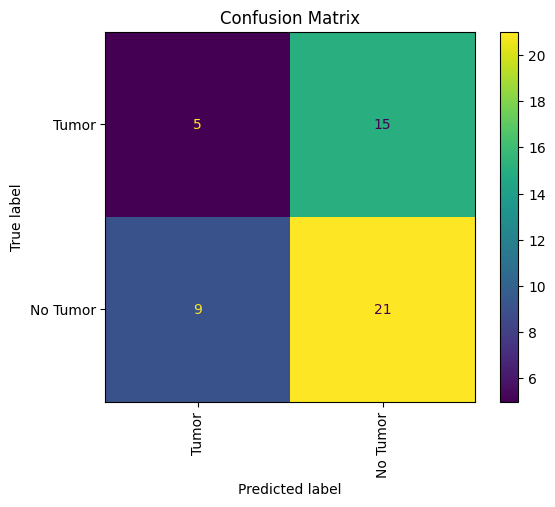

In [124]:
plot_confusion_matrix(model, test_ds)

**ResNet50V2 - Deep Neural Network with Augmented Data**

In [158]:
aug_train_ds = augmented_data(244, 244)
checkpoint = tf.keras.callbacks.ModelCheckpoint('../models/resnet50v2aug_best.h5', 
                                                monitor='accuracy', verbose=1, 
                                                mode='max',save_best_only=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', factor=0.3, patience=4, min_lr=0.0000001)
callbacks_list = [checkpoint,early,reduce_lr]

history = model.fit(aug_train_ds, epochs=30, callbacks=callbacks_list)

Found 200 images belonging to 2 classes.


Epoch 1/30
20/20 [==============================] - ETA: 0s - loss: 0.0529 - accuracy: 0.9700
Epoch 1: accuracy improved from -inf to 0.97000, saving model to ../models\resnet50v2aug_best.h5
20/20 [==============================] - 24s 1s/step - loss: 0.0529 - accuracy: 0.9700 - lr: 0.0010
Epoch 2/30
20/20 [==============================] - ETA: 0s - loss: 0.0491 - accuracy: 0.9900
Epoch 2: accuracy improved from 0.97000 to 0.99000, saving model to ../models\resnet50v2aug_best.h5
20/20 [==============================] - 29s 1s/step - loss: 0.0491 - accuracy: 0.9900 - lr: 0.0010
Epoch 3/30
20/20 [==============================] - ETA: 0s - loss: 0.1092 - accuracy: 0.9650
Epoch 3: accuracy did not improve from 0.99000
20/20 [==============================] - 28s 1s/step - loss: 0.1092 - accuracy: 0.9650 - lr: 0.0010
Epoch 4/30
20/20 [==============================] - ETA: 0s - loss: 0.0530 - accuracy: 0.9800
Epoch 4: accuracy did not improve from 0.99000
20/20 [==========================

In [6]:
model = load_model('../models/resnet50v2aug_best.h5')
start_time = time.time()
history_2 = model.evaluate(test_ds)
end_time = time.time()
inference_time = end_time-start_time
print(f"Inference time: {inference_time}")

5/5 [==============================] - 7s 977ms/step - loss: 0.9733 - accuracy: 0.7600
Inference time: 7.080042362213135


In [8]:
output_path = "../models/resnet50v2aug_best.onnx"
spec = [(tf.TensorSpec(shape=(None, 244, 244, 3), dtype=tf.float32, name="input"))]

model_proto, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=13)
onnx.save_model(model_proto, output_path)

In [10]:
providers = ['CPUExecutionProvider']
session = ort.InferenceSession(output_path, providers=providers)
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

correct_predictions_total = 0
total_inference_time = 0
n_samples = 0

for batch in (test_ds):

    image, label = batch
    input_data = image

    start_time = time.time()
    onnx_pred = session.run([output_name], {input_name: input_data})
    end_time = time.time()
    
    threshold = 0.5
    binary_predictions = (onnx_pred[0] > threshold).astype(int)

    inference_time = (end_time-start_time)
    total_inference_time +=inference_time

    correct_predictions_batch = (binary_predictions.T == label)
    correct_predictions_total += np.sum(correct_predictions_batch)
    n_samples += len(label)

    if test_ds.batch_index == 0:
        break

print(f"Correct predictions: {correct_predictions_total}")
print(f"Total predictions: {n_samples}")
accuracy = (correct_predictions_total/n_samples)
onnx_inference_time = total_inference_time/len(test_ds)
print(f"Accuracy {accuracy:.2f}")
print(f"Inference time: {onnx_inference_time:.4f}")

Correct predictions: 38
Total predictions: 50
Accuracy 0.76
Inference time: 0.9163


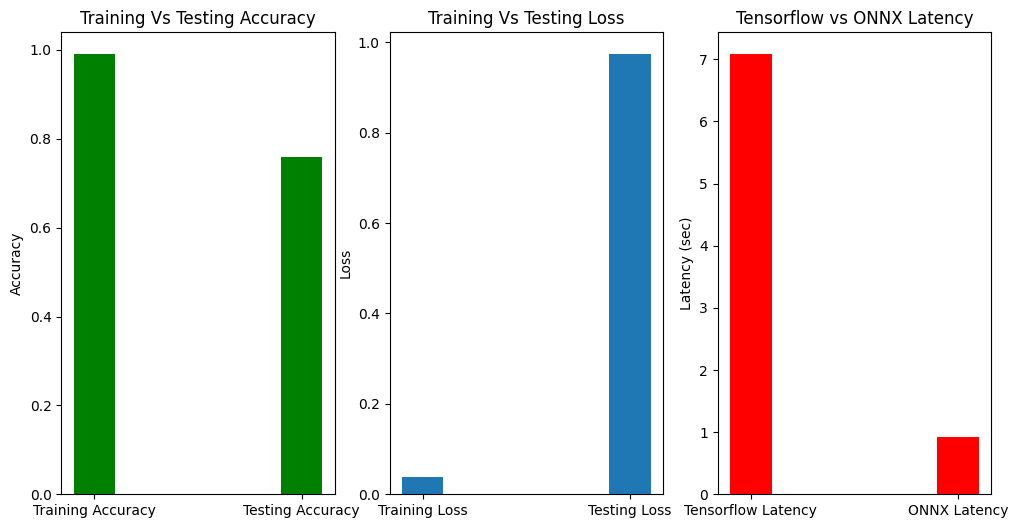

In [13]:
plots(0.99, 0.76, 0.0374, 0.9733, 7.080, 0.9163)

5/5 [==============================] - 6s 925ms/step


<Figure size 800x800 with 0 Axes>

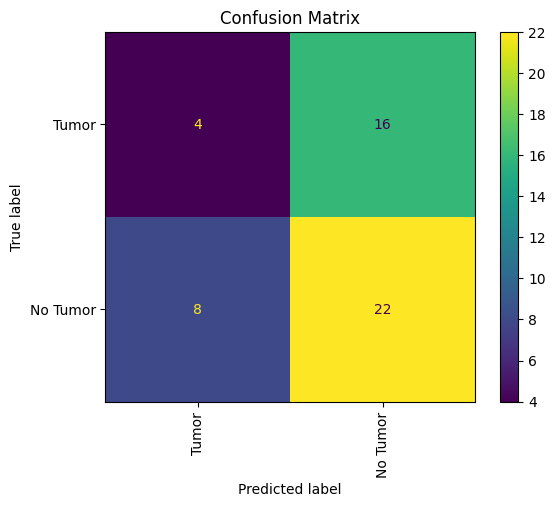

In [163]:
plot_confusion_matrix(model, test_ds)

**VGG19 - Deep Neural Network**

In [175]:
tf.keras.backend.clear_session()

#initializing new height and width for images
train_ds, test_ds = image_gen(224, 224, batch_size)

base_model = VGG19(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

base_model.trainable = False

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer=Adam(), 
               loss="binary_crossentropy", 
               metrics=['accuracy'])
model.summary()

checkpoint = tf.keras.callbacks.ModelCheckpoint('../models/vgg19_best.h5', 
                                                monitor='accuracy', verbose=1, 
                                                mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="accuracy", mode="max", restore_best_weights=True, patience=5)
callbacks_list = [checkpoint,early]

history = model.fit(train_ds, epochs=30, callbacks=callbacks_list)

Found 200 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 20049473 (76.48 MB)
Trainable params: 25089 (98.00 KB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________
Epoch 1/30
20/20 [==============================] - ETA: 0s - loss: 0.8509 - accuracy: 0.6300
Epoch 1: accuracy improved from -inf to 0.63000, 

In [176]:
model = load_model('../models/vgg19_best.h5')
start_time = time.time()
history_2 = model.evaluate(test_ds)
end_time = time.time()
inference_time = (end_time-start_time)
print(f"Inference time: {inference_time}")

5/5 [==============================] - 16s 3s/step - loss: 0.6357 - accuracy: 0.8400
Inference time: 16.454569578170776


In [178]:
output_path = "../models/vgg19_best.h5.onnx"
spec = [(tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name="input"))]

model_proto, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=13)
onnx.save_model(model_proto, output_path)

Could not search for non-variable resources. Concrete function internal representation may have changed.


In [179]:
providers = ['CPUExecutionProvider']
session = ort.InferenceSession(output_path, providers=providers)
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

correct_predictions_total = 0
total_inference_time = 0
n_samples = 0

for batch in (test_ds):

    image, label = batch
    input_data = image

    start_time = time.time()
    onnx_pred = session.run([output_name], {input_name: input_data})
    end_time = time.time()
    
    threshold = 0.5
    binary_predictions = (onnx_pred[0] > threshold).astype(int)

    inference_time = (end_time-start_time)
    total_inference_time +=inference_time

    correct_predictions_batch = (binary_predictions.T == label)
    correct_predictions_total += np.sum(correct_predictions_batch)
    n_samples += len(label)

    if test_ds.batch_index == 0:
        break

print(f"Correct predictions: {correct_predictions_total}")
print(f"Total predictions: {n_samples}")
accuracy = (correct_predictions_total/n_samples)
onnx_inference_time_inference_time = total_inference_time/len(test_ds)
print(f"Accuracy {accuracy:.2f}")
print(f"Inference time: {onnx_inference_time:.4f}")

Correct predictions: 42
Total predictions: 50
Accuracy 0.84
Inference time: 0.8694


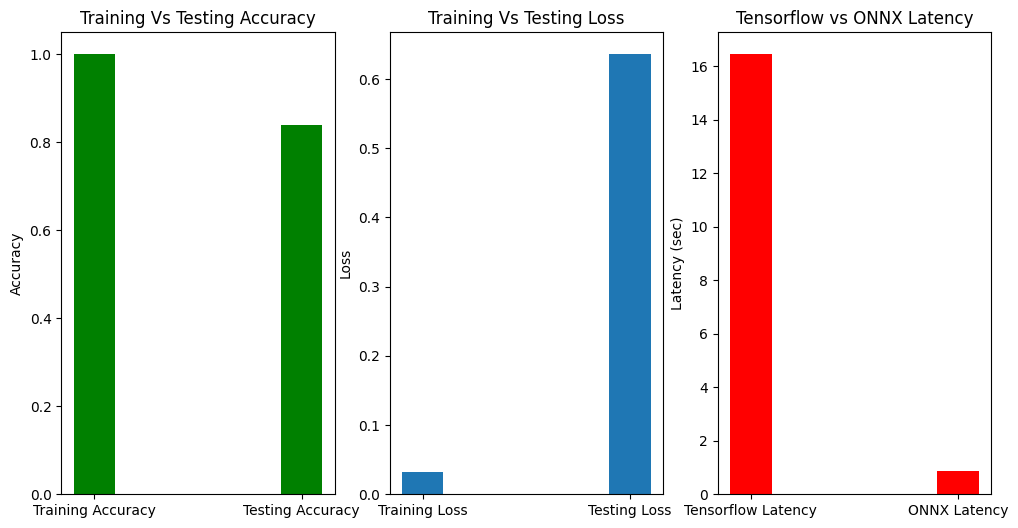

In [14]:
plots(1.00, 0.84, 0.0326, 0.6357, 16.454, 0.8694)

5/5 [==============================] - 16s 3s/step


<Figure size 800x800 with 0 Axes>

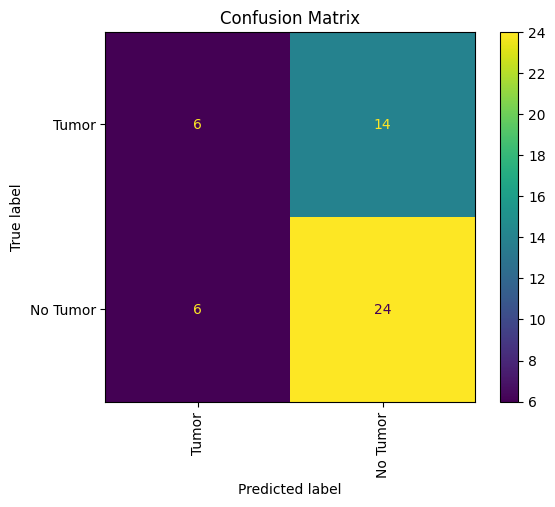

In [181]:
plot_confusion_matrix(model, test_ds)

**VGG19 - Deep Neural Network with Augmented Data**

In [183]:
aug_train_ds = augmented_data(224, 224)
checkpoint = tf.keras.callbacks.ModelCheckpoint('../models/vgg19_aug.h5', 
                                                monitor='accuracy', verbose=1, 
                                                mode='max',save_best_only=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', factor=0.3, patience=3, min_lr=0.0000001)
callbacks_list = [checkpoint,early,reduce_lr]

history = model.fit(aug_train_ds, epochs=15, callbacks=callbacks_list)

Found 200 images belonging to 2 classes.


Epoch 1/15
20/20 [==============================] - ETA: 0s - loss: 0.3061 - accuracy: 0.8750
Epoch 1: accuracy improved from -inf to 0.87500, saving model to ../models\vgg19_aug.h5
20/20 [==============================] - 60s 3s/step - loss: 0.3061 - accuracy: 0.8750 - lr: 0.0010
Epoch 2/15
20/20 [==============================] - ETA: 0s - loss: 0.4232 - accuracy: 0.8150
Epoch 2: accuracy did not improve from 0.87500
20/20 [==============================] - 59s 3s/step - loss: 0.4232 - accuracy: 0.8150 - lr: 0.0010
Epoch 3/15
20/20 [==============================] - ETA: 0s - loss: 0.2938 - accuracy: 0.9000
Epoch 3: accuracy improved from 0.87500 to 0.90000, saving model to ../models\vgg19_aug.h5
20/20 [==============================] - 58s 3s/step - loss: 0.2938 - accuracy: 0.9000 - lr: 0.0010
Epoch 4/15
20/20 [==============================] - ETA: 0s - loss: 0.2822 - accuracy: 0.8850
Epoch 4: accuracy did not improve from 0.90000
20/20 [==============================] - 60s 3s/ste

In [184]:
model = load_model('../models/vgg19_aug.h5')
start_time = time.time()
history_2 = model.evaluate(test_ds)
end_time = time.time()
inference_time = (end_time-start_time)
print(f"Inference time: {inference_time}")

5/5 [==============================] - 15s 3s/step - loss: 0.5434 - accuracy: 0.8600
Inference time: 15.012403011322021


In [185]:
output_path = "../models/vgg19_aug.h5.onnx"
spec = [(tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name="input"))]

model_proto, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=13)
onnx.save_model(model_proto, output_path)

Could not search for non-variable resources. Concrete function internal representation may have changed.


In [186]:
providers = ['CPUExecutionProvider']
session = ort.InferenceSession(output_path, providers=providers)
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

correct_predictions_total = 0
total_inference_time = 0
n_samples = 0

for batch in (test_ds):

    image, label = batch
    input_data = image

    start_time = time.time()
    onnx_pred = session.run([output_name], {input_name: input_data})
    end_time = time.time()
    
    threshold = 0.5
    binary_predictions = (onnx_pred[0] > threshold).astype(int)

    inference_time = (end_time-start_time)
    total_inference_time +=inference_time

    correct_predictions_batch = (binary_predictions.T == label)
    correct_predictions_total += np.sum(correct_predictions_batch)
    n_samples += len(label)

    if test_ds.batch_index == 0:
        break

print(f"Correct predictions: {correct_predictions_total}")
print(f"Total predictions: {n_samples}")
accuracy = (correct_predictions_total/n_samples)
onnx_inference_time_inference_time = total_inference_time/len(test_ds)
print(f"Accuracy {accuracy:.2f}")
print(f"Inference time: {onnx_inference_time:.4f}")

Correct predictions: 43
Total predictions: 50
Accuracy 0.86
Inference time: 0.8694


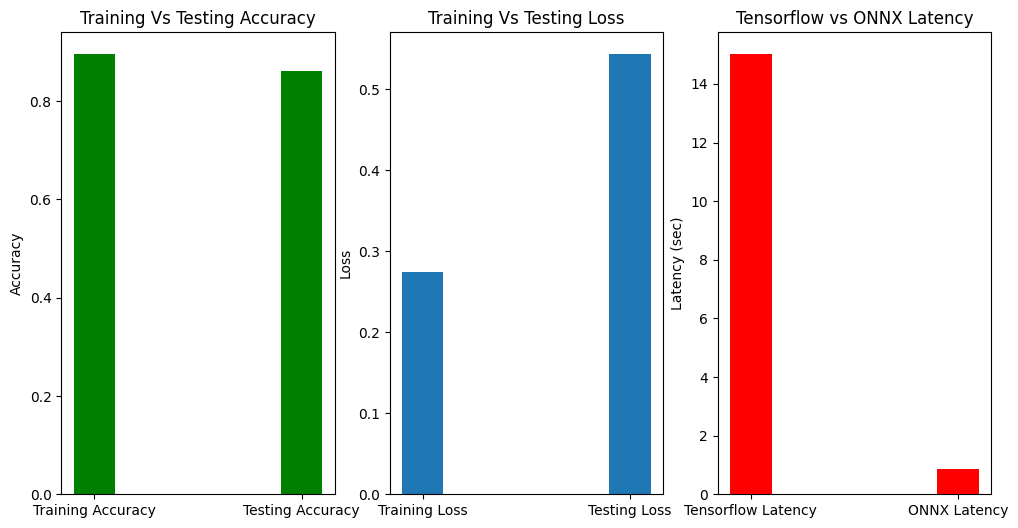

In [15]:
plots(0.8950, 0.86, 0.2749, 0.5434, 15.01, 0.8694)

5/5 [==============================] - 14s 3s/step


<Figure size 800x800 with 0 Axes>

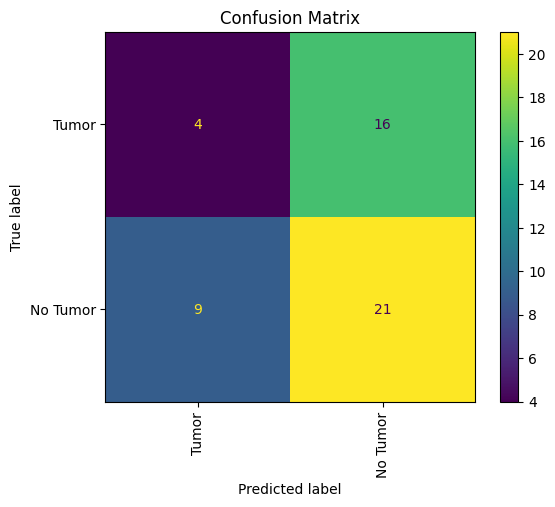

In [188]:
plot_confusion_matrix(model, test_ds)

**VGG16 - Deep Neural Network**

In [189]:
tf.keras.backend.clear_session()

base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

base_model.trainable = False

model = keras.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(0.001), metrics=['accuracy'])

checkpoint = tf.keras.callbacks.ModelCheckpoint('../models/vgg16_best.h5', 
                                                monitor='accuracy', verbose=1, 
                                                mode='max',save_best_only=True)

early = tf.keras.callbacks.EarlyStopping(monitor="accuracy", mode="max", restore_best_weights=True, patience=3)

callbacks_list = [checkpoint,early]

history = model.fit(train_ds,
           epochs=15,
           shuffle=True,
           verbose=True,
           callbacks=callbacks_list
          )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 14739777 (56.23 MB)
Trainable params: 25089 (98.00 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________
Epoch 1/15
20/20 [==============================] - ETA: 0s - loss: 0.6236 - accuracy: 0.7200
Epoch 1: accuracy improved from -inf to 0.72000, saving model to vgg16_best.h5
20/20 [==============================] - 50s 2s/step - loss: 0.6236 - accuracy: 0.7200
Epoch 2/15
20/2

In [190]:
model = load_model('../models/vgg16_best.h5')
start_time = time.time()
history_2 = model.evaluate(test_ds)
end_time = time.time()
inference_time = (end_time-start_time)
print(f"Inference time: {inference_time}")

5/5 [==============================] - 11s 2s/step - loss: 0.5542 - accuracy: 0.7200
Inference time: 11.111437320709229


In [21]:
output_path = "../models/vgg16_best.h5.onnx"
spec = [(tf.TensorSpec(shape=(None, 244, 244, 3), dtype=tf.float32, name="input"))]

# model_proto, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=13)
# onnx.save_model(model_proto, output_path)

In [19]:
providers = ['CPUExecutionProvider']
session = ort.InferenceSession(output_path, providers=providers)
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

correct_predictions_total = 0
total_inference_time = 0
n_samples = 0

for batch in (test_ds):

    image, label = batch
    input_data = image

    start_time = time.time()
    onnx_pred = session.run([output_name], {input_name: input_data})
    end_time = time.time()
    
    threshold = 0.5
    binary_predictions = (onnx_pred[0] > threshold).astype(int)

    inference_time = (end_time-start_time)
    total_inference_time +=inference_time

    correct_predictions_batch = (binary_predictions.T == label)
    correct_predictions_total += np.sum(correct_predictions_batch)
    n_samples += len(label)

    if test_ds.batch_index == 0:
        break

print(f"Correct predictions: {correct_predictions_total}")
print(f"Total predictions: {n_samples}")
accuracy = (correct_predictions_total/n_samples)
onnx_inference_time_inference_time = total_inference_time/len(test_ds)
print(f"Accuracy {accuracy:.2f}")
print(f"Inference time: {onnx_inference_time:.4f}")

InvalidArgument: [ONNXRuntimeError] : 2 : INVALID_ARGUMENT : Got invalid dimensions for input: input for the following indices
 index: 1 Got: 244 Expected: 224
 index: 2 Got: 244 Expected: 224
 Please fix either the inputs or the model.

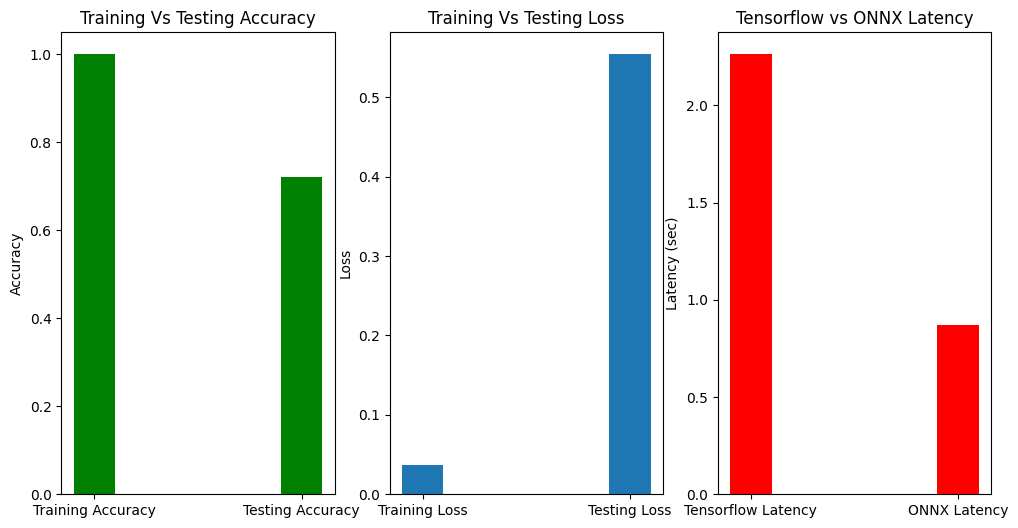

In [193]:
plots(1, 0.72, 0.0364, 0.5542, 11.111, 0.8694  )

5/5 [==============================] - 11s 2s/step


<Figure size 800x800 with 0 Axes>

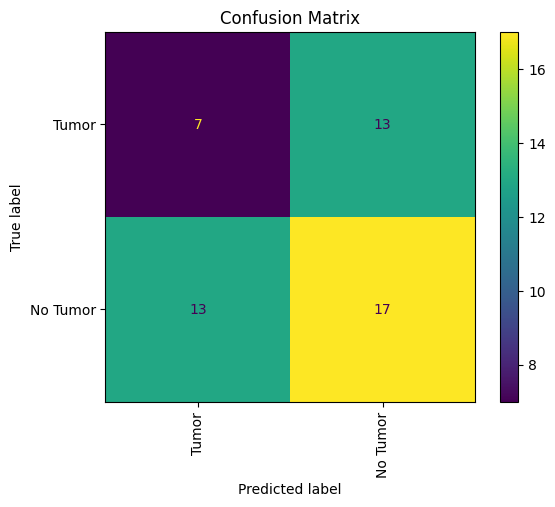

In [194]:
plot_confusion_matrix(model, test_ds)

**VGG16 - Deep Neural Network with Augmented Data**

In [195]:
aug_train_ds = augmented_data(224, 224)
checkpoint = tf.keras.callbacks.ModelCheckpoint('../models/vgg16_aug.h5', 
                                                monitor='accuracy', verbose=1, 
                                                mode='max',save_best_only=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', factor=0.3, patience=3, min_lr=0.0000001)
callbacks_list = [checkpoint,early,reduce_lr]

history = model.fit(aug_train_ds, epochs=15, callbacks=callbacks_list)

Found 200 images belonging to 2 classes.


Epoch 1/15
20/20 [==============================] - ETA: 0s - loss: 0.3506 - accuracy: 0.8400
Epoch 1: accuracy improved from -inf to 0.84000, saving model to ../models\vgg16_aug.h5
20/20 [==============================] - 54s 3s/step - loss: 0.3506 - accuracy: 0.8400 - lr: 0.0010
Epoch 2/15
20/20 [==============================] - ETA: 0s - loss: 0.3607 - accuracy: 0.8550
Epoch 2: accuracy improved from 0.84000 to 0.85500, saving model to ../models\vgg16_aug.h5
20/20 [==============================] - 69s 3s/step - loss: 0.3607 - accuracy: 0.8550 - lr: 0.0010
Epoch 3/15
20/20 [==============================] - ETA: 0s - loss: 0.2831 - accuracy: 0.8800
Epoch 3: accuracy improved from 0.85500 to 0.88000, saving model to ../models\vgg16_aug.h5
20/20 [==============================] - 56s 3s/step - loss: 0.2831 - accuracy: 0.8800 - lr: 0.0010
Epoch 4/15
20/20 [==============================] - ETA: 0s - loss: 0.2594 - accuracy: 0.8850
Epoch 4: accuracy improved from 0.88000 to 0.88500, sa

In [196]:
model = load_model('../models/vgg16_aug.h5')
start_time = time.time()
model.evaluate(test_ds)
end_time = time.time()
inference_time = (end_time-start_time)
print(f"Inference time: {inference_time}")

5/5 [==============================] - 11s 2s/step - loss: 0.4984 - accuracy: 0.8400
Inference time: 11.070435762405396


In [197]:
output_path = "../models/vgg16_best.h5.onnx"
spec = [(tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name="input"))]

model_proto, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=13)
onnx.save_model(model_proto, output_path)

Could not search for non-variable resources. Concrete function internal representation may have changed.


In [198]:
providers = ['CPUExecutionProvider']
session = ort.InferenceSession(output_path, providers=providers)
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

correct_predictions_total = 0
total_inference_time = 0
n_samples = 0

for batch in (test_ds):

    image, label = batch
    input_data = image

    start_time = time.time()
    onnx_pred = session.run([output_name], {input_name: input_data})
    end_time = time.time()
    
    threshold = 0.5
    binary_predictions = (onnx_pred[0] > threshold).astype(int)

    inference_time = (end_time-start_time)
    total_inference_time +=inference_time

    correct_predictions_batch = (binary_predictions.T == label)
    correct_predictions_total += np.sum(correct_predictions_batch)
    n_samples += len(label)

    if test_ds.batch_index == 0:
        break

print(f"Correct predictions: {correct_predictions_total}")
print(f"Total predictions: {n_samples}")
accuracy = (correct_predictions_total/n_samples)
onnx_inference_time_inference_time = total_inference_time/len(test_ds)
print(f"Accuracy {accuracy:.2f}")
print(f"Inference time: {onnx_inference_time:.4f}")

Correct predictions: 42
Total predictions: 50
Accuracy 0.84
Inference time: 0.8694


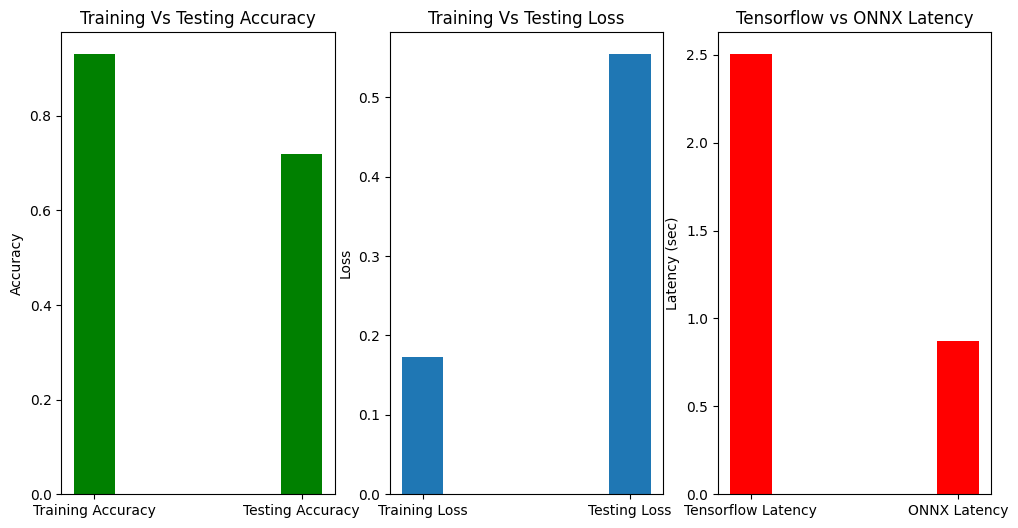

In [199]:
plots(history.history['accuracy'][-1], history_2[1], history.history['loss'][-1], history_2[0],
       inference_time, onnx_inference_time)

5/5 [==============================] - 10s 2s/step


<Figure size 800x800 with 0 Axes>

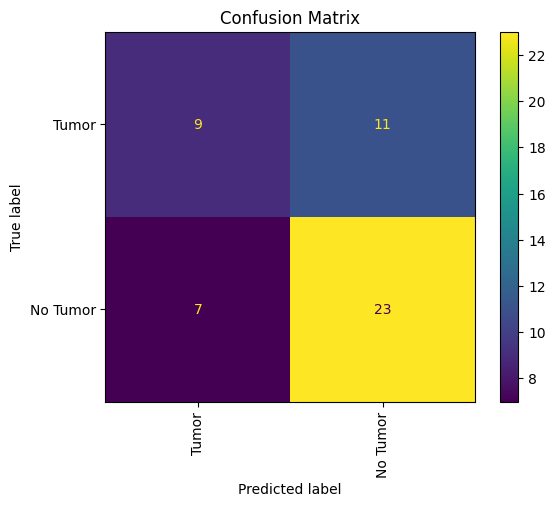

In [200]:
plot_confusion_matrix(model, test_ds)

**End of File**